In [1]:
import numpy as np
from torch.utils.data import DataLoader
import torch
from matplotlib import pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from models import Classifier, Metrics, find_threshold, DataSet, WeightedMSE, FlatLoss
from matplotlib.cm import get_cmap
np.random.seed(42)

# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

In [2]:
n_s = int(5e4)
n_b = int(5e4)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,n_s)
u_ = np.random.uniform(0,1,n_b)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T


z_b = np.random.normal(0,1,n_b)
z_s = np.random.normal(0.5,1,n_s)
z_t = np.random.normal(0,1,n_b)

# fig ,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,8),dpi=120)

# _,bins,_ = ax1.hist(m_b,bins=40,density=True,alpha=0.5, label='background')
# ax1.hist(m_s,bins=bins,density=True,alpha=0.5,label='signal')
# ax1.legend()
# ax1.set_xlabel(r"$m$")
# ax1.set_ylabel("Normed Counts")

# ax2.scatter(x_b,y_b,s=5,alpha=0.4)
# ax2.scatter(x_s,y_s,s=5,alpha=0.4)
# ax2.set_xlabel(r"$x$")
# ax2.set_ylabel(r"$y$")

# _,bins,_ = ax3.hist(m_b**2+2.5*m_b,bins=40,density=True,alpha=0.5, label='background')
# ax3.hist(m_s**2+2.5*m_s,bins=bins,density=True,alpha=0.5,label='signal')
# ax3.set_xlabel(r"$m^2 + 2m$")

# _,bins,_ = ax4.hist(z_b,bins=40,density=True,alpha=0.5, label='background')
# ax4.hist(z_s,bins=bins,density=True,alpha=0.5,label='signal')
# ax4.set_xlabel(r"$z$")

# #ax2.set_title("Data")
# fig.tight_layout()
# plt.savefig("./plots/Data.pdf")
# plt.show()

In [3]:
x = np.concatenate([np.stack([m_s,m_s**2+2*m_s,x_s,y_s,z_s],axis=1),
                   np.stack([m_b,m_b**2+2*m_b,x_b,y_b,z_b],axis=1)])

y = np.concatenate([np.zeros(m_s.size),np.ones(m_b.size)])

x_test = np.stack([m_t,m_t**2+2*m_t,x_t,y_t,z_t],axis=1) 

# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]


traindataset = DataSet(x_train[::,1:].astype('float32'),y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset = DataSet(x_val[::,1:].astype('float32'),y_val.astype('int32'),x_val[::,0].astype('float32'))
testTensor= torch.from_numpy(x_test[::,1:]).float()

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('device used in training:', device)

device used in training: cpu


In [5]:
my_cmap = get_cmap('viridis')
my_cmap.set_bad(my_cmap.colors[0])

params = {'epochs'       : 1500,
          'interval'     : 100,
          'batch_size'   : 1024,
          'shuffle'      : True,
          'num_workers'  : 6,
          'drop_last'    :True,
          'device'       : device,
          'pass_x_biased': True,
         }

Entering Training...
Epoch:0100/2000 || Train: loss:0.2460, acc:62% || Test: loss: 0.2457, acc:62%, R50: 3.7155, 1/JSD: 10.6764  || 75.2s
Epoch:0200/2000 || Train: loss:0.2389, acc:64% || Test: loss: 0.2387, acc:64%, R50: 4.2197, 1/JSD: 10.3214  || 151.7s
Epoch:0300/2000 || Train: loss:0.2290, acc:65% || Test: loss: 0.2288, acc:65%, R50: 4.4517, 1/JSD: 8.4104  || 231.5s
Epoch:0400/2000 || Train: loss:0.2207, acc:66% || Test: loss: 0.2204, acc:66%, R50: 4.6560, 1/JSD: 11.7497  || 308.7s
Epoch:0500/2000 || Train: loss:0.2140, acc:67% || Test: loss: 0.2136, acc:67%, R50: 5.0190, 1/JSD: 13.3045  || 388.7s
Epoch:0600/2000 || Train: loss:0.2075, acc:69% || Test: loss: 0.2071, acc:68%, R50: 5.6138, 1/JSD: 11.8603  || 469.8s
Epoch:0700/2000 || Train: loss:0.2001, acc:71% || Test: loss: 0.1998, acc:71%, R50: 6.4173, 1/JSD: 10.3570  || 547.4s
Epoch:0800/2000 || Train: loss:0.1915, acc:73% || Test: loss: 0.1914, acc:73%, R50: 7.6373, 1/JSD: 7.1653  || 627.5s
Epoch:0900/2000 || Train: loss:0.1832,

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


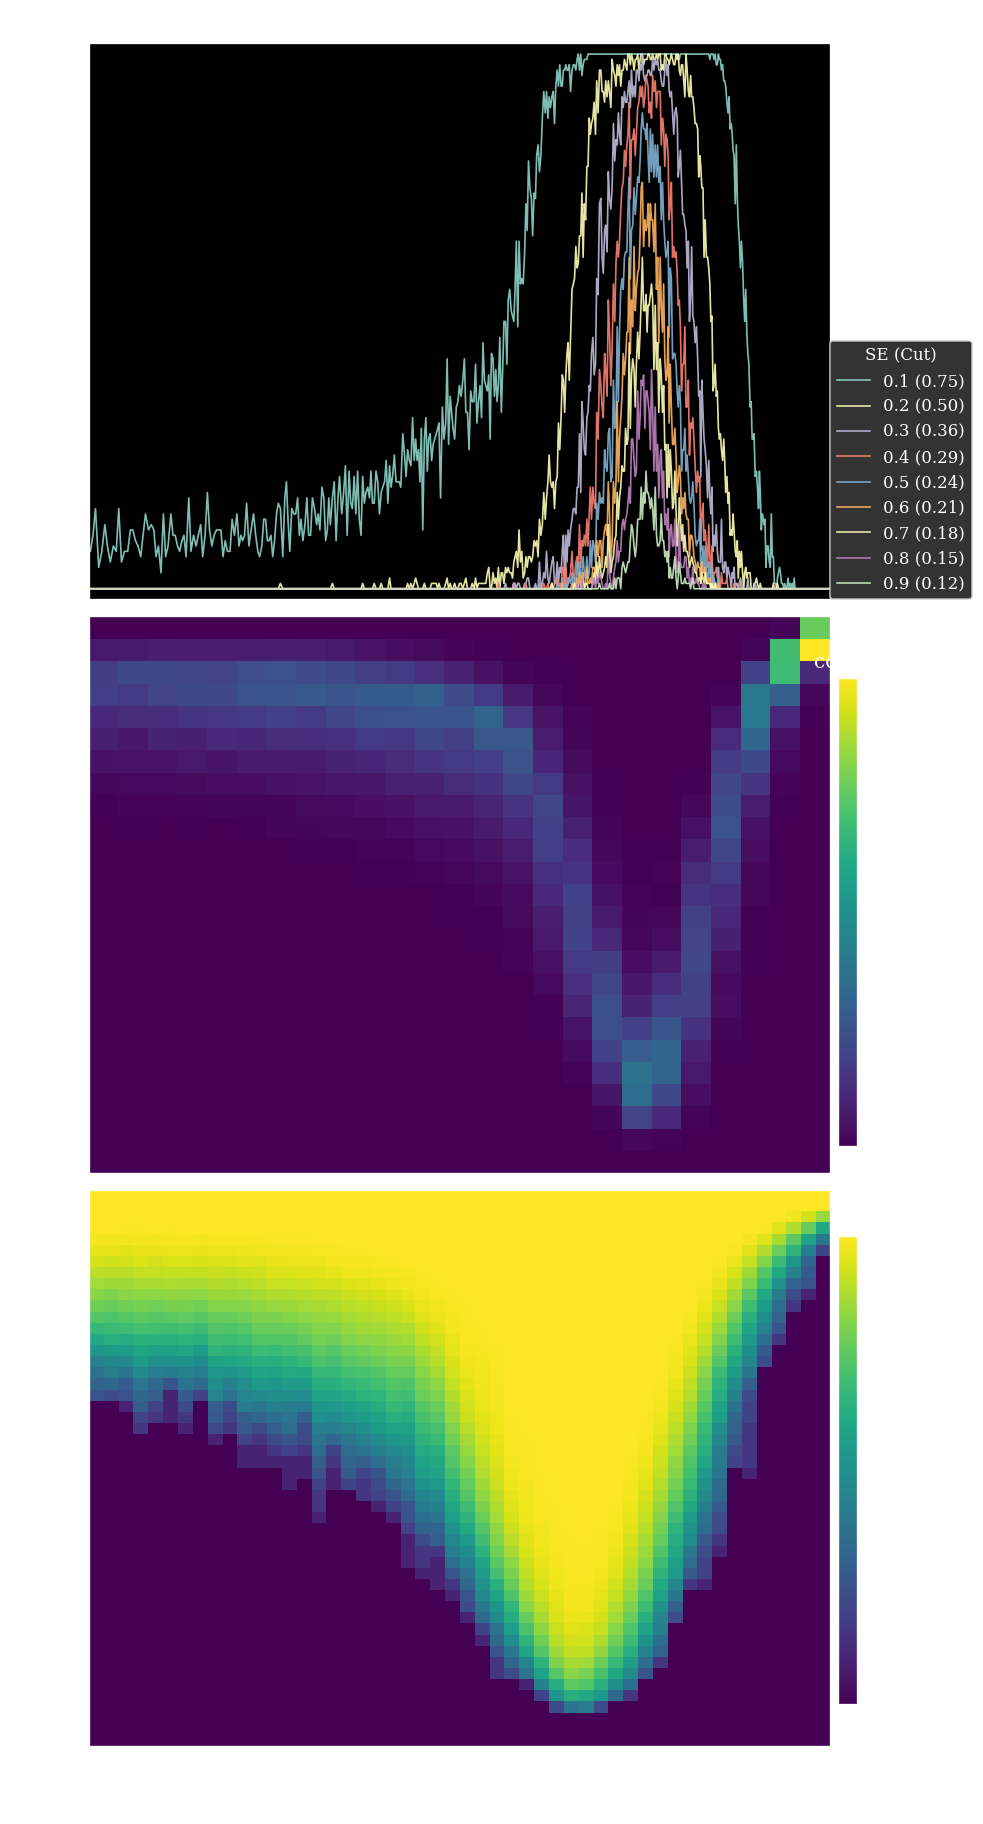

Entering Training...
Epoch:0100/2000 || Train: loss:0.1645, acc:64% || Test: loss: 0.2464, acc:64%, R50: 3.7558, 1/JSD: 6.1766  || 77.9s
Epoch:0200/2000 || Train: loss:0.1614, acc:65% || Test: loss: 0.2418, acc:65%, R50: 3.9276, 1/JSD: 6.3724  || 158.6s
Epoch:0300/2000 || Train: loss:0.1569, acc:65% || Test: loss: 0.2351, acc:65%, R50: 4.0060, 1/JSD: 6.5630  || 236.0s
Epoch:0400/2000 || Train: loss:0.1518, acc:65% || Test: loss: 0.2276, acc:65%, R50: 4.1346, 1/JSD: 6.2268  || 314.8s
Epoch:0500/2000 || Train: loss:0.1478, acc:66% || Test: loss: 0.2215, acc:66%, R50: 4.2591, 1/JSD: 6.5439  || 393.8s
Epoch:0600/2000 || Train: loss:0.1447, acc:66% || Test: loss: 0.2168, acc:66%, R50: 4.4915, 1/JSD: 7.0131  || 473.1s
Epoch:0700/2000 || Train: loss:0.1420, acc:67% || Test: loss: 0.2128, acc:67%, R50: 4.7892, 1/JSD: 8.9406  || 556.3s
Epoch:0800/2000 || Train: loss:0.1394, acc:68% || Test: loss: 0.2088, acc:68%, R50: 5.1795, 1/JSD: 11.6168  || 639.3s
Epoch:0900/2000 || Train: loss:0.1367, acc:

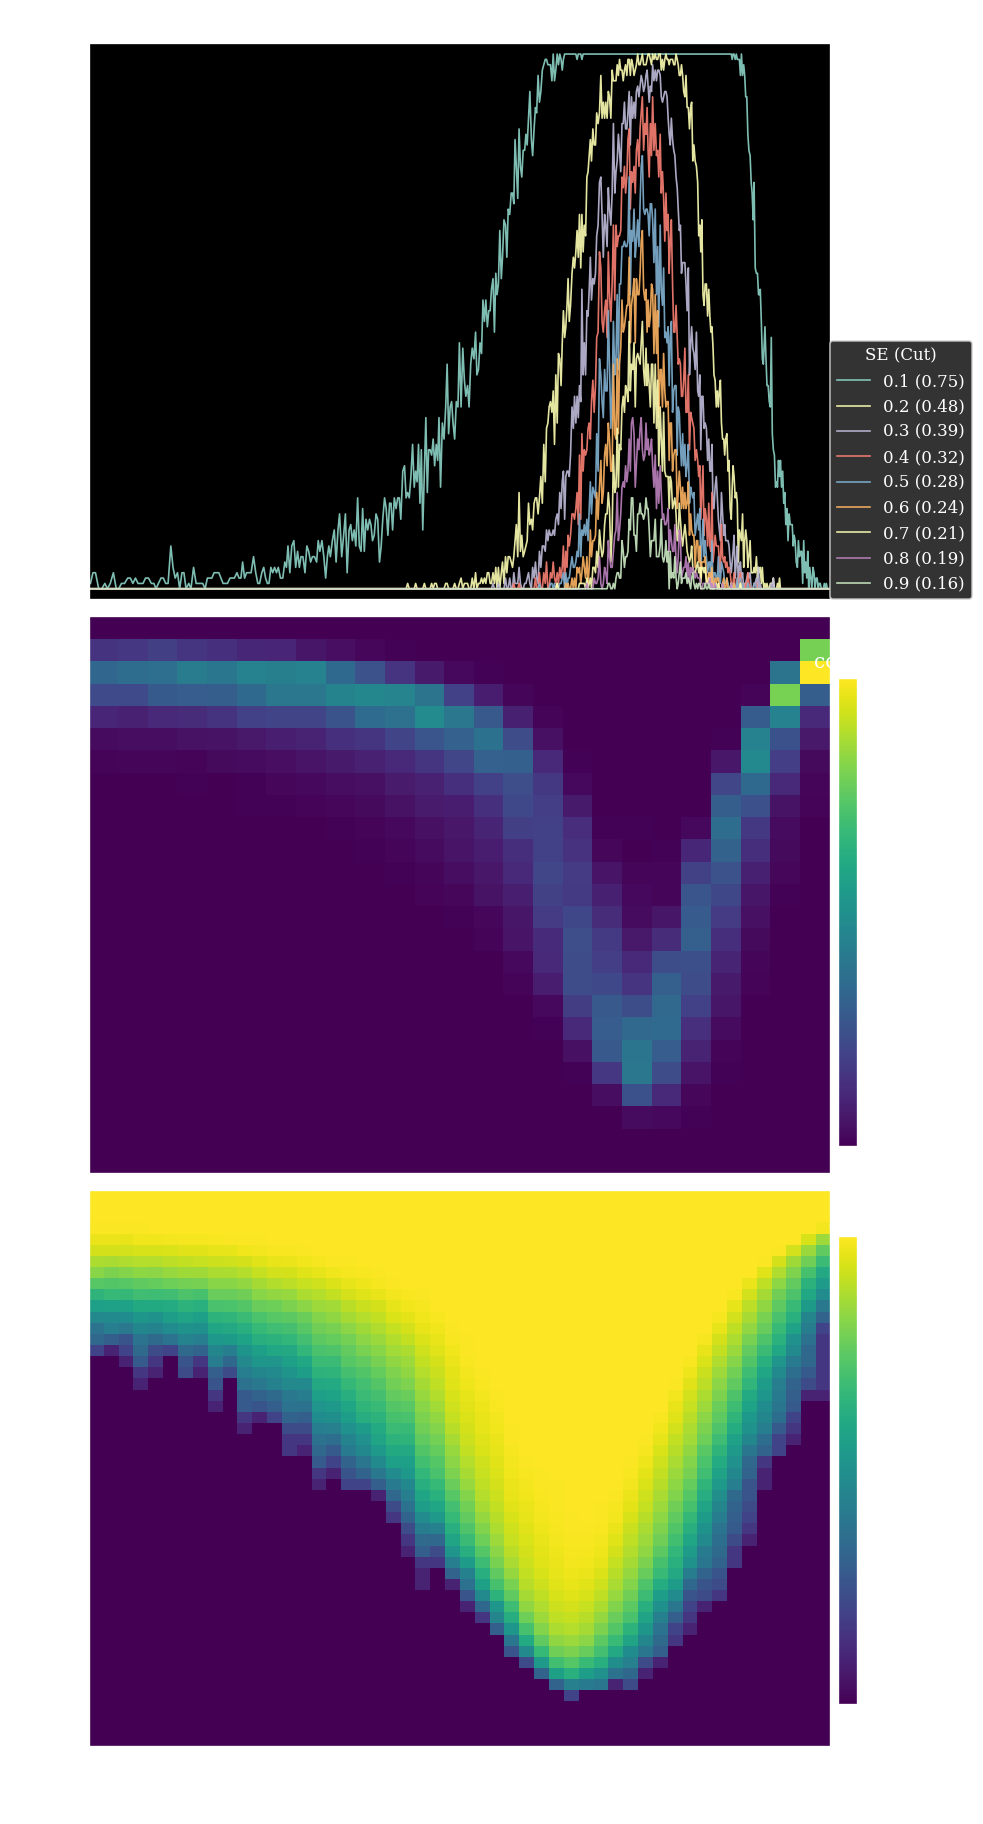

Entering Training...
Epoch:0100/2000 || Train: loss:0.1224, acc:66% || Test: loss: 0.2444, acc:65%, R50: 3.7970, 1/JSD: 5.2614  || 80.3s
Epoch:0200/2000 || Train: loss:0.1195, acc:66% || Test: loss: 0.2386, acc:65%, R50: 4.0076, 1/JSD: 6.4232  || 159.6s
Epoch:0300/2000 || Train: loss:0.1162, acc:66% || Test: loss: 0.2319, acc:66%, R50: 4.0842, 1/JSD: 7.0920  || 242.0s
Epoch:0400/2000 || Train: loss:0.1128, acc:66% || Test: loss: 0.2252, acc:66%, R50: 4.1863, 1/JSD: 8.2474  || 324.7s
Epoch:0500/2000 || Train: loss:0.1101, acc:67% || Test: loss: 0.2196, acc:66%, R50: 4.3589, 1/JSD: 9.1987  || 404.9s
Epoch:0700/2000 || Train: loss:0.1064, acc:67% || Test: loss: 0.2123, acc:67%, R50: 4.7597, 1/JSD: 10.0151  || 573.0s
Epoch:0800/2000 || Train: loss:0.1050, acc:68% || Test: loss: 0.2096, acc:68%, R50: 5.0366, 1/JSD: 10.2971  || 652.4s
Epoch:0900/2000 || Train: loss:0.1037, acc:69% || Test: loss: 0.2070, acc:68%, R50: 5.3620, 1/JSD: 10.3859  || 731.9s
Epoch:1000/2000 || Train: loss:0.1024, ac

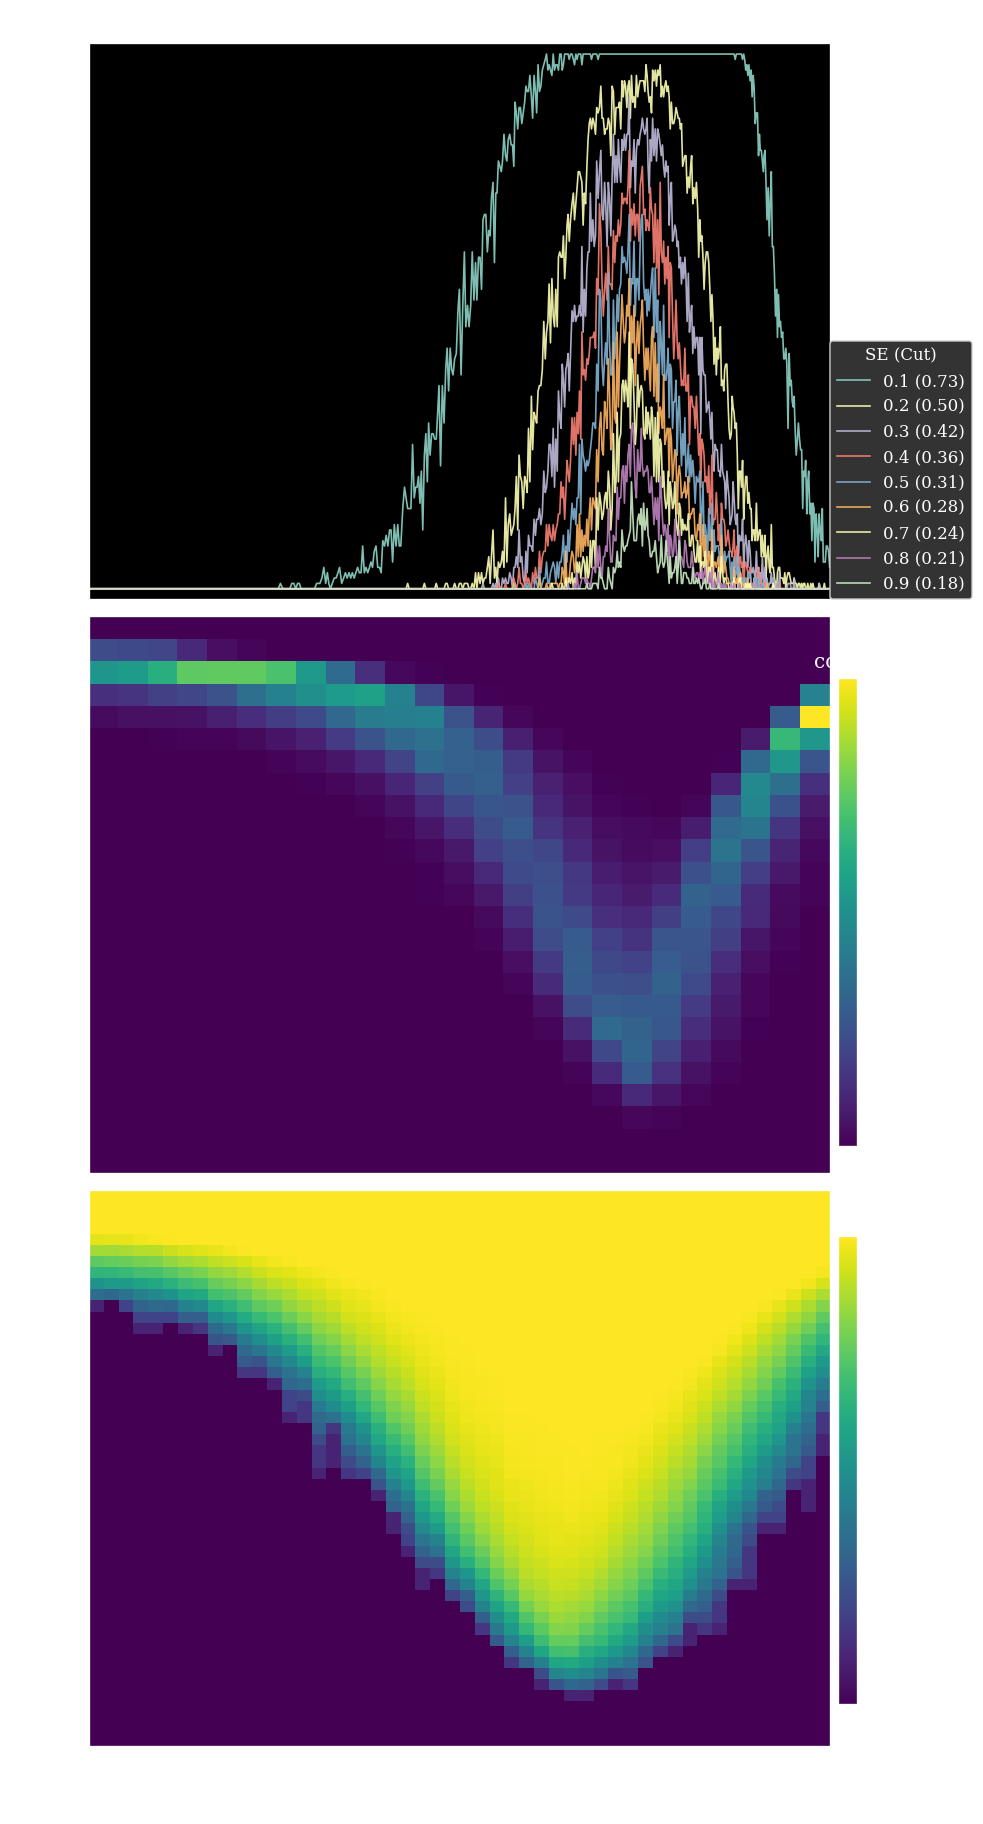

Entering Training...
Epoch:0100/2000 || Train: loss:0.0825, acc:62% || Test: loss: 0.2473, acc:62%, R50: 3.3860, 1/JSD: 8.1569  || 80.0s
Epoch:0200/2000 || Train: loss:0.0815, acc:64% || Test: loss: 0.2443, acc:64%, R50: 3.6923, 1/JSD: 6.3927  || 163.4s
Epoch:0300/2000 || Train: loss:0.0804, acc:64% || Test: loss: 0.2409, acc:64%, R50: 3.8085, 1/JSD: 6.2897  || 246.2s
Epoch:0400/2000 || Train: loss:0.0791, acc:65% || Test: loss: 0.2370, acc:65%, R50: 3.8761, 1/JSD: 5.9905  || 326.1s
Epoch:0500/2000 || Train: loss:0.0777, acc:65% || Test: loss: 0.2329, acc:65%, R50: 3.9477, 1/JSD: 5.8878  || 409.4s
Epoch:0600/2000 || Train: loss:0.0764, acc:65% || Test: loss: 0.2289, acc:65%, R50: 4.0269, 1/JSD: 6.3621  || 488.1s
Epoch:0700/2000 || Train: loss:0.0752, acc:65% || Test: loss: 0.2254, acc:65%, R50: 4.0875, 1/JSD: 6.1415  || 568.8s
Epoch:0800/2000 || Train: loss:0.0743, acc:65% || Test: loss: 0.2226, acc:65%, R50: 4.1363, 1/JSD: 5.8985  || 652.6s
Epoch:0900/2000 || Train: loss:0.0736, acc:6

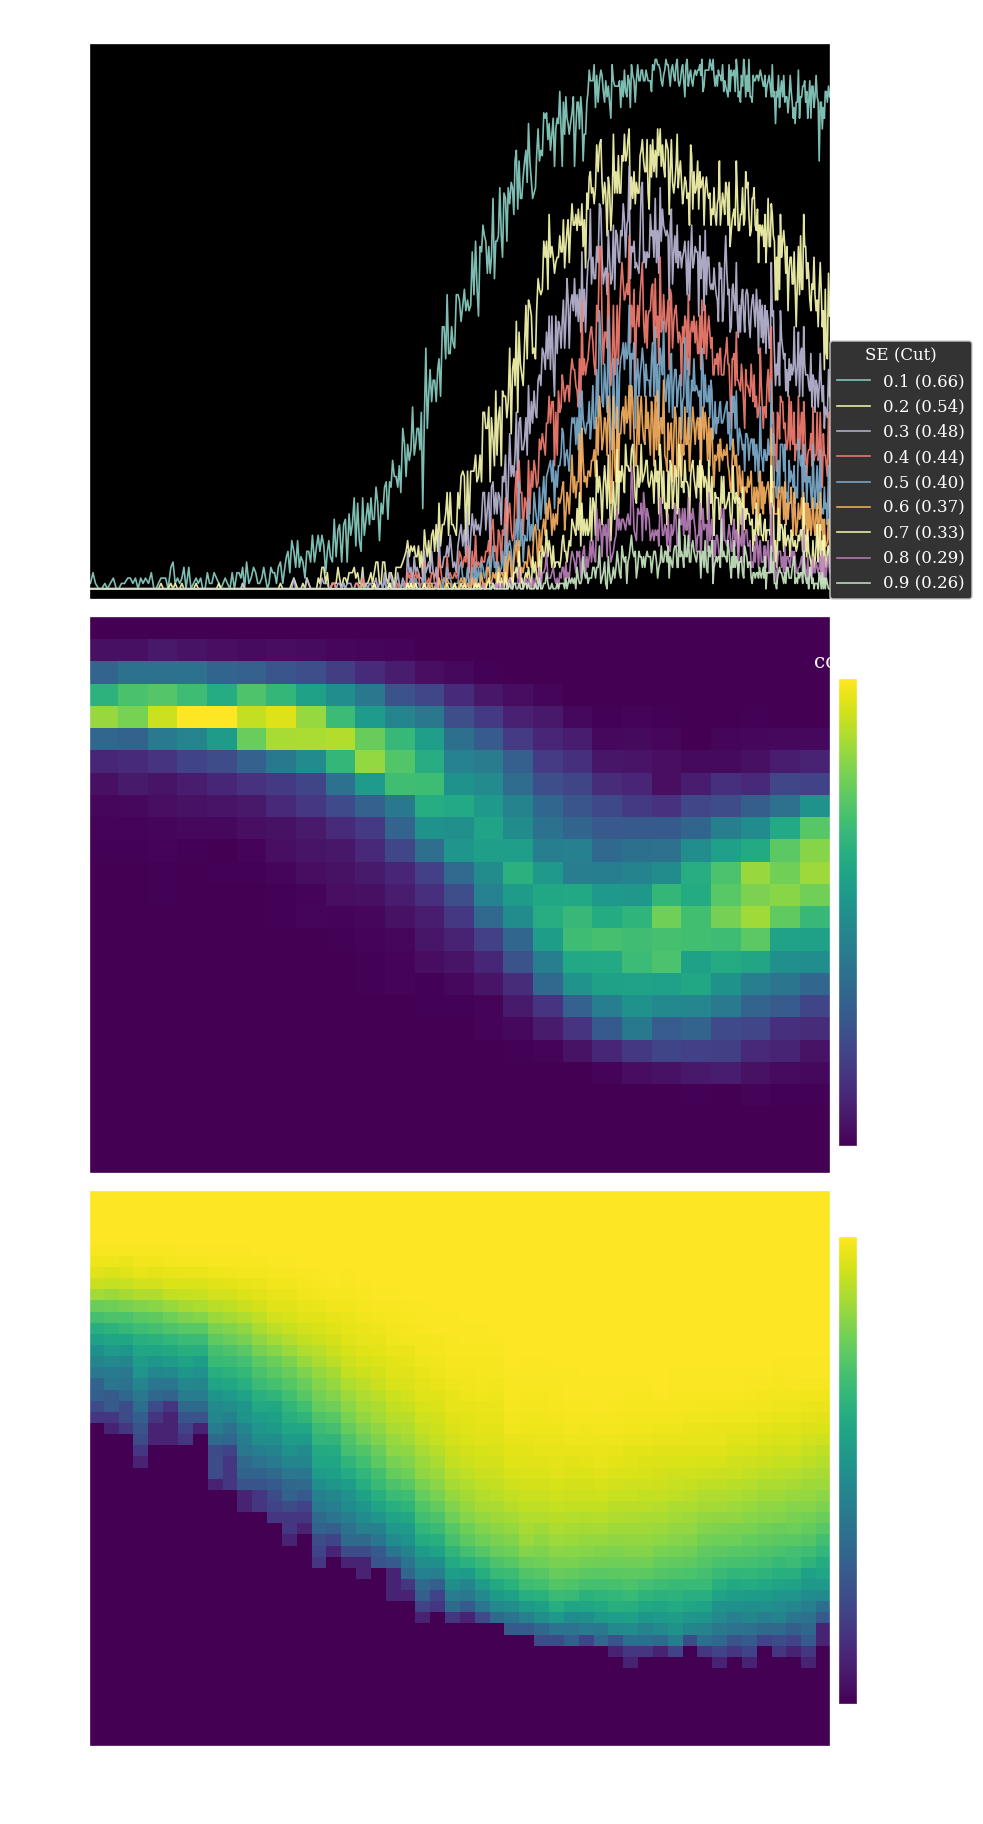

Entering Training...
Epoch:0100/2000 || Train: loss:0.0621, acc:58% || Test: loss: 0.2479, acc:59%, R50: 4.7239, 1/JSD: 9.8407  || 84.7s
Epoch:0200/2000 || Train: loss:0.0617, acc:65% || Test: loss: 0.2466, acc:65%, R50: 5.0015, 1/JSD: 10.6783  || 168.7s
Epoch:0300/2000 || Train: loss:0.0614, acc:66% || Test: loss: 0.2451, acc:66%, R50: 4.9866, 1/JSD: 9.2320  || 249.3s
Epoch:0400/2000 || Train: loss:0.0609, acc:66% || Test: loss: 0.2433, acc:66%, R50: 4.8493, 1/JSD: 8.6139  || 333.3s
Epoch:0500/2000 || Train: loss:0.0604, acc:66% || Test: loss: 0.2413, acc:66%, R50: 4.8353, 1/JSD: 8.1692  || 413.9s
Epoch:0600/2000 || Train: loss:0.0598, acc:66% || Test: loss: 0.2388, acc:66%, R50: 4.7733, 1/JSD: 8.0700  || 494.6s
Epoch:0700/2000 || Train: loss:0.0591, acc:67% || Test: loss: 0.2359, acc:66%, R50: 4.7195, 1/JSD: 8.3303  || 578.4s
Epoch:0800/2000 || Train: loss:0.0582, acc:67% || Test: loss: 0.2325, acc:67%, R50: 4.7150, 1/JSD: 7.8157  || 658.5s
Epoch:0900/2000 || Train: loss:0.0573, acc:

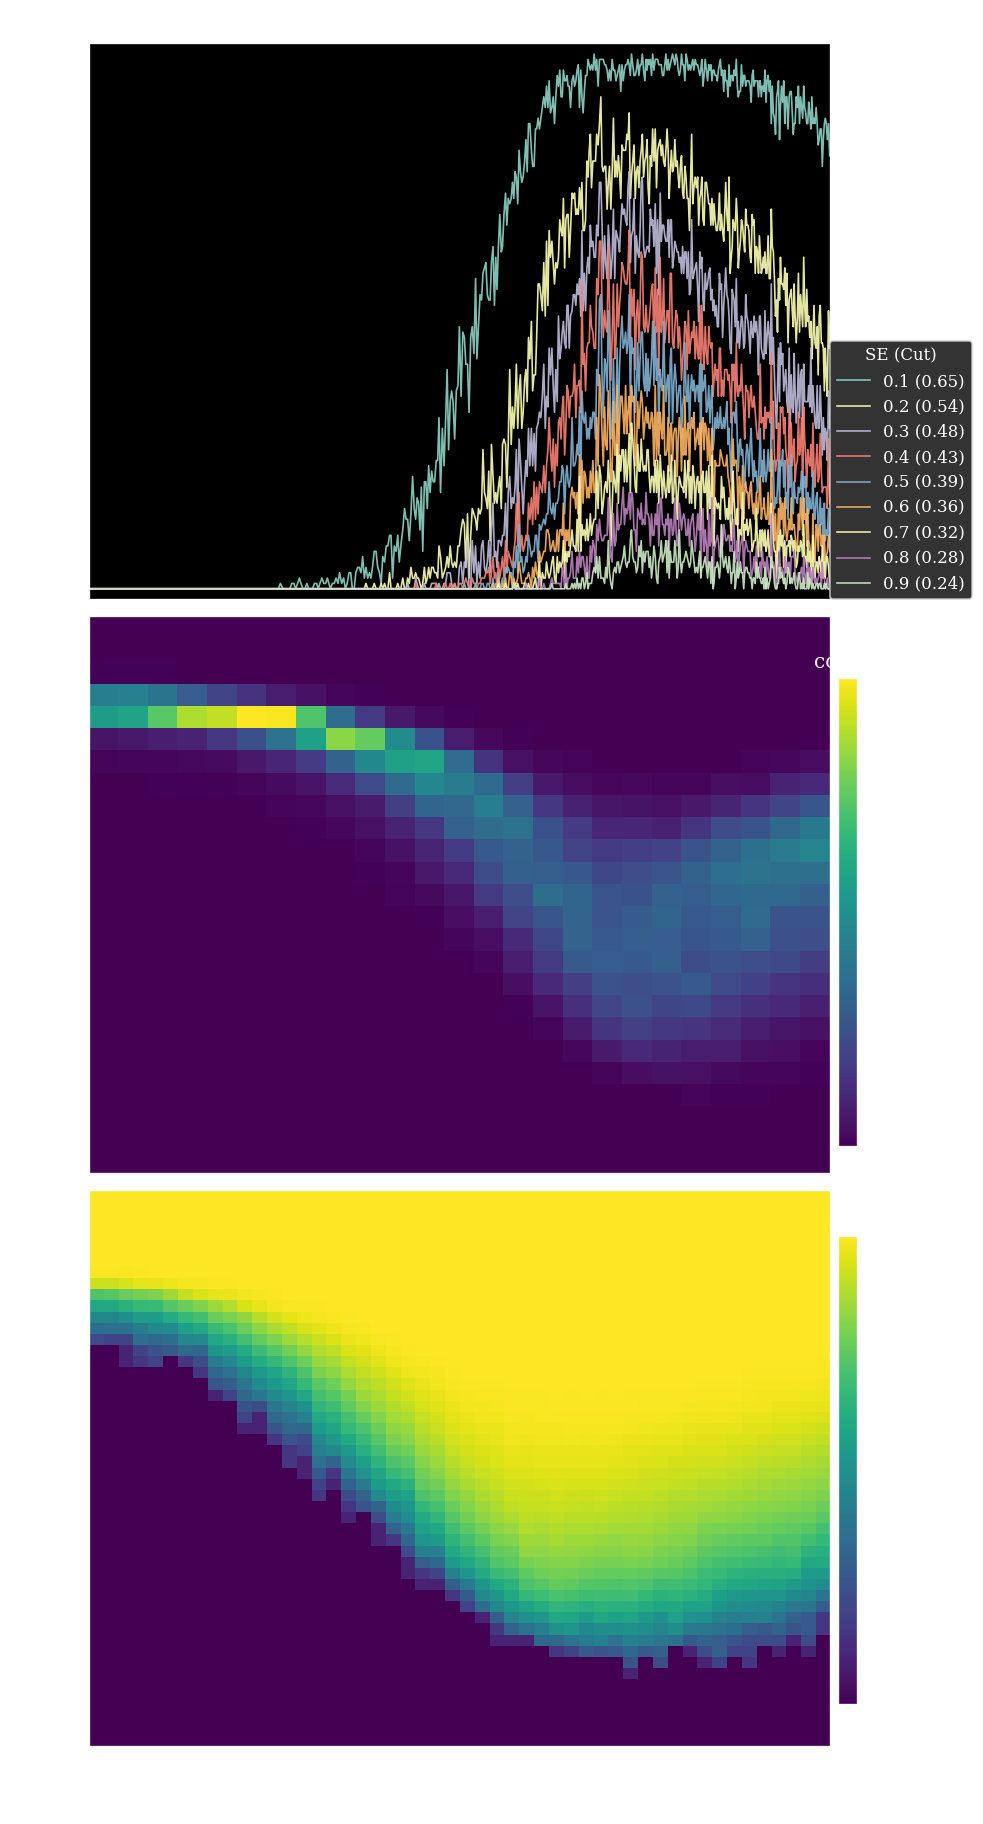

Entering Training...
Epoch:0100/2000 || Train: loss:0.0418, acc:47% || Test: loss: 0.2501, acc:48%, R50: 2.0425, 1/JSD: 13.1199  || 80.8s
Epoch:0200/2000 || Train: loss:0.0417, acc:55% || Test: loss: 0.2495, acc:55%, R50: 2.5152, 1/JSD: 5.8505  || 161.6s
Epoch:0300/2000 || Train: loss:0.0416, acc:64% || Test: loss: 0.2489, acc:63%, R50: 3.0015, 1/JSD: 4.3548  || 245.0s
Epoch:0400/2000 || Train: loss:0.0415, acc:64% || Test: loss: 0.2483, acc:64%, R50: 3.3860, 1/JSD: 4.1670  || 324.3s
Epoch:0500/2000 || Train: loss:0.0413, acc:64% || Test: loss: 0.2477, acc:64%, R50: 3.5639, 1/JSD: 4.5202  || 405.0s
Epoch:0600/2000 || Train: loss:0.0412, acc:64% || Test: loss: 0.2470, acc:64%, R50: 3.7558, 1/JSD: 4.9475  || 484.8s
Epoch:0700/2000 || Train: loss:0.0411, acc:64% || Test: loss: 0.2463, acc:64%, R50: 3.8987, 1/JSD: 5.3602  || 563.9s
Epoch:0800/2000 || Train: loss:0.0410, acc:64% || Test: loss: 0.2456, acc:64%, R50: 4.0220, 1/JSD: 5.8915  || 647.4s
Epoch:0900/2000 || Train: loss:0.0408, acc:

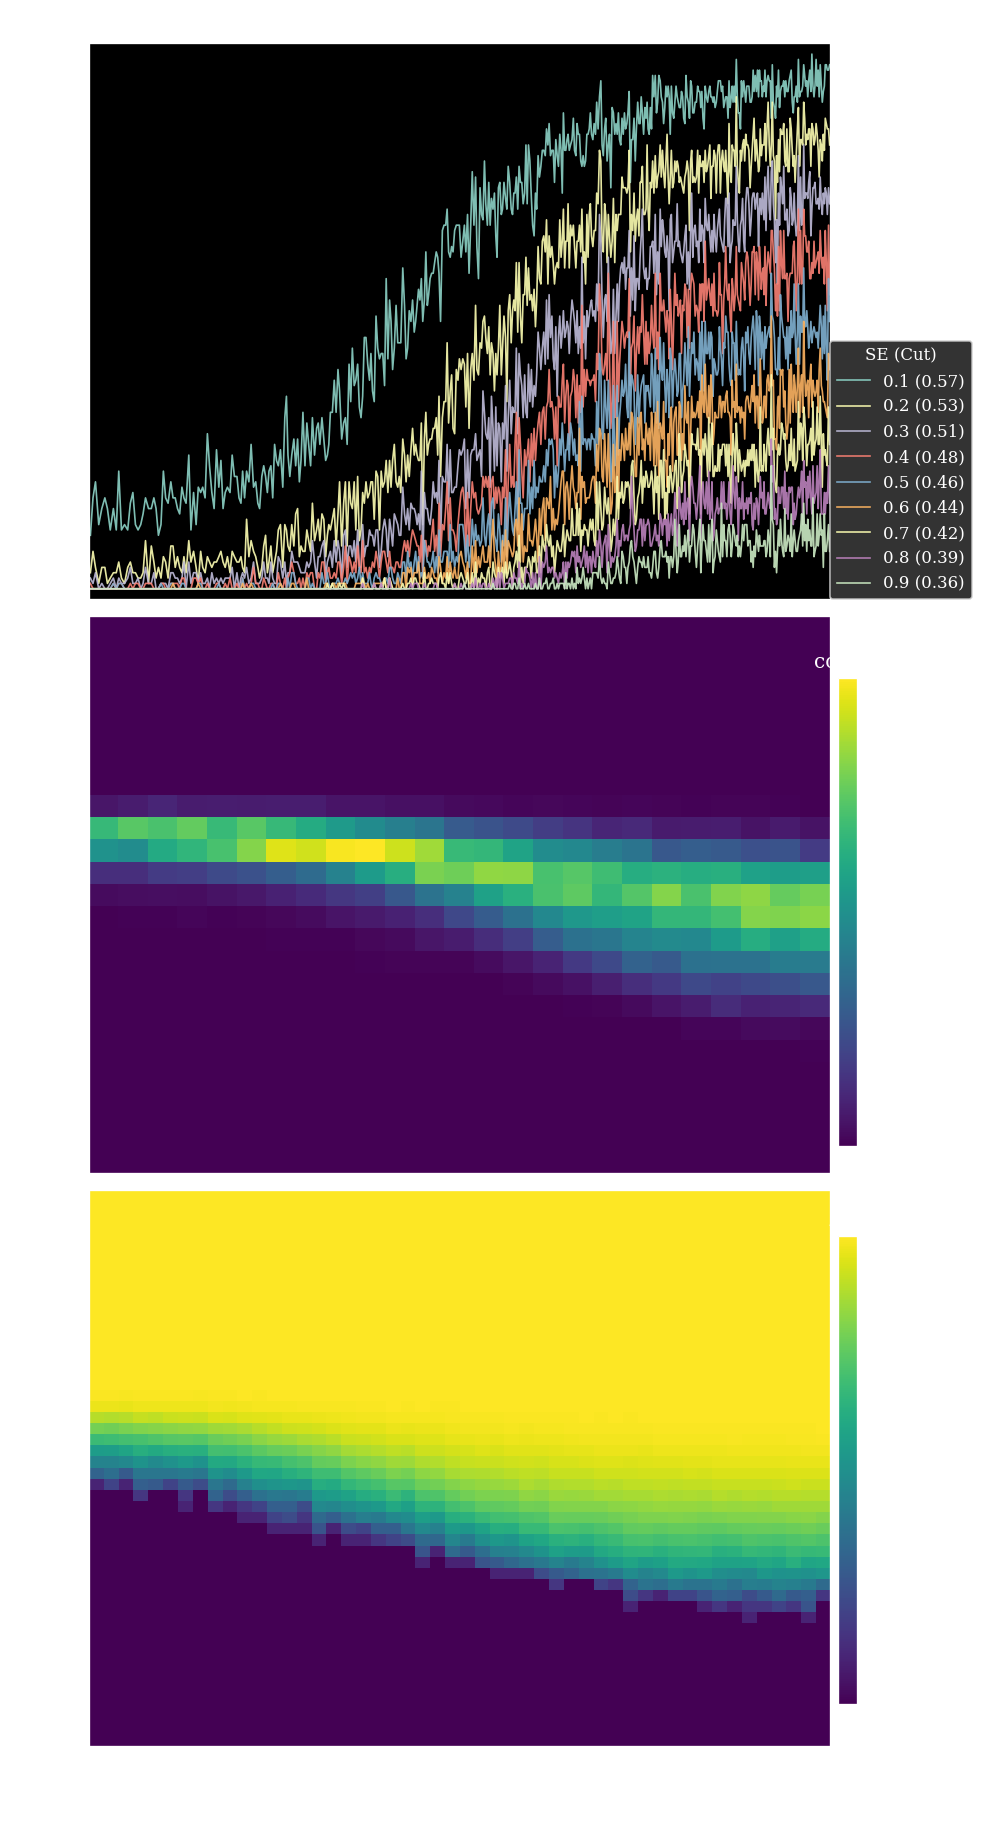

Entering Training...
Epoch:0100/2000 || Train: loss:0.0226, acc:56% || Test: loss: 0.2475, acc:57%, R50: 2.6954, 1/JSD: 11.9837  || 81.4s
Epoch:0200/2000 || Train: loss:0.0225, acc:59% || Test: loss: 0.2464, acc:59%, R50: 2.9547, 1/JSD: 10.1931  || 166.0s
Epoch:0300/2000 || Train: loss:0.0224, acc:61% || Test: loss: 0.2454, acc:61%, R50: 3.1711, 1/JSD: 8.9972  || 246.5s
Epoch:0400/2000 || Train: loss:0.0223, acc:61% || Test: loss: 0.2444, acc:61%, R50: 3.3069, 1/JSD: 8.3551  || 326.9s
Epoch:0500/2000 || Train: loss:0.0222, acc:62% || Test: loss: 0.2434, acc:62%, R50: 3.4276, 1/JSD: 7.6648  || 407.5s
Epoch:0600/2000 || Train: loss:0.0221, acc:62% || Test: loss: 0.2424, acc:62%, R50: 3.5030, 1/JSD: 7.1545  || 488.0s
Epoch:0700/2000 || Train: loss:0.0220, acc:63% || Test: loss: 0.2414, acc:62%, R50: 3.5677, 1/JSD: 7.0290  || 571.7s


KeyboardInterrupt: 

In [6]:
torch.manual_seed(69)
efficiencies = np.linspace(0.1,0.9,9)
for strength in [0,0.5,1,2,3,5,10,15,20]:
    frac = strength/(1+strength)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics(validation=True)
    model_legendre = Classifier(input_size=4)
    model_legendre.loss = FlatLoss(frac=frac,labels=y_train,bins=100,
                                   background_only=False,norm='L2',recalculate=False)
    model_legendre.fit(traindataset=traindataset,
                       valdataset=valdataset,
                       **params,
                       optimizer=torch.optim.SGD(model_legendre.parameters(),lr=1e-1,momentum=0.),
                       #scheduler=scheduler,
                       metrics=[metrics_train_legendre,metrics_val_legendre])
    
    validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(validation_predictions,(y_val==0),eff))
    
    
    scores = np.array(model_legendre(testTensor).tolist()).reshape(-1,100)
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=50,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
    for j,cut in enumerate(cuts):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
    ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

    _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])
    cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
    cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
    cb.ax.set_title("counts")
    ax2.set_ylabel(r"$s$",fontsize=17)

    im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
    ax3.set_ylabel(r"$s$",fontsize=17)

    cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
    cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
    cb.ax.set_title(r"$F(s)$")
    ax3.set_xlabel(r"$m$",fontsize=19)

    fig.tight_layout(pad=0)
    plt.show()